# Soal 5

1. [Fit logistik regression model menggunakan income dan balance untuk memprediksi default](#1)
2. [Dengan Validation Set Approach, estimasi test error dari model ini](#2)
3. [Ulangi langkah nomor dua dengan 3 jenis validation set](#3)
4. [Tambahkan student variable dalam model](#4)

## 1

In [1]:
import pandas as pd
import numpy as np
import patsy
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [2]:
from scipy import stats
stats.chisqrprob = lambda chisq, df: stats.chi2.sf(chisq, df)

sns.set(style='white')
%matplotlib inline

In [3]:
np.random.seed(1)
default = pd.read_csv('../dataset/Default.csv', index_col=0)

In [4]:
default.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


In [5]:
default['default_yes'] = (default['default'] == 'Yes').astype('int')

In [6]:
default.head()

,default,student,balance,income,default_yes
1,No,No,729.526495,44361.625074,0
2,No,Yes,817.180407,12106.134700,0
3,No,No,1073.549164,31767.138947,0
4,No,No,529.250605,35704.493935,0
5,No,No,785.655883,38463.495879,0


In [7]:
default.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 5 columns):
default        10000 non-null object
student        10000 non-null object
balance        10000 non-null float64
income         10000 non-null float64
default_yes    10000 non-null int64
dtypes: float64(2), int64(1), object(2)
memory usage: 468.8+ KB


In [8]:
LR = LogisticRegression(C=10**6, tol=1e-6)
X = default[['income', 'balance']]
Y = default['default_yes']
model = LR.fit(X, Y)
model.coef_

/home/uulwake/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[2.07267113e-05, 5.64079143e-03]])

In [9]:
f = 'default_yes ~ income + balance'
result = smf.logit(formula=f, data=default).fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.078948
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            default_yes   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Thu, 21 Feb 2019   Pseudo R-squ.:                  0.4594
Time:                        09:57:51   Log-Likelihood:                -789.48
converged:                       True   LL-Null:                       -1460.3
                                        LLR p-value:                4.541e-292
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.5405      0.435    -26.544      0.000     -12.393     -10.688
income      2.081e-05   4.99e-06      4.174      0.000     1.1e-05    3.06e-05
balance        0.0056      0.000     24.835      0.000       0.005       0.006
==============================================================================

Possibly complete quasi-separation: A fraction 0.14 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

[kembali ke atas](#Soal-5)

## 2

In [10]:
# i
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

In [11]:
# ii
model = LR.fit(X_train, Y_train)
model.coef_

/home/uulwake/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[1.62553551e-05, 5.83500517e-03]])

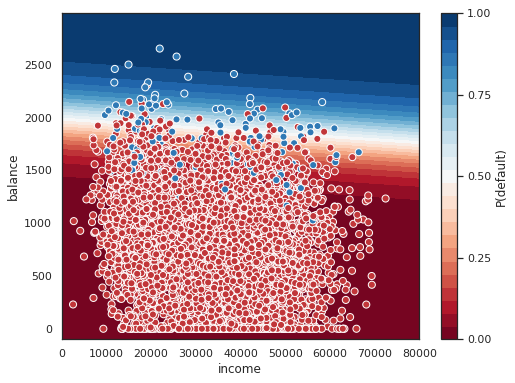

In [12]:
# iii
xx, yy = np.mgrid[0:80000:100, -100:3000:10]
grid = np.c_[xx.ravel(), yy.ravel()]                    
# https://www.quora.com/Can-anybody-elaborate-the-use-of-c_-in-numpy
probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)

f, ax = plt.subplots(figsize=(8,6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",    # 25 levels
                     vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("P(default)")
ax_c.set_ticks([0,0.25,0.5,.75,1])

ax.scatter(X_test['income'], X_test['balance'], c=Y_test, s=50, 
          cmap="RdBu", vmin=-0.2, vmax=1.2,
          edgecolor="white", linewidth=1)

ax.set(xlabel="income", ylabel="balance");

In [13]:
# iv
Y_pred = model.predict(X_test)
Y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [14]:
test_error = 1 - (Y_pred == Y_test).mean()
test_error * 100

2.500000000000002

In [15]:
# confusion matrix
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."

    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.4f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.4f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.4f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.4f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.4f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()

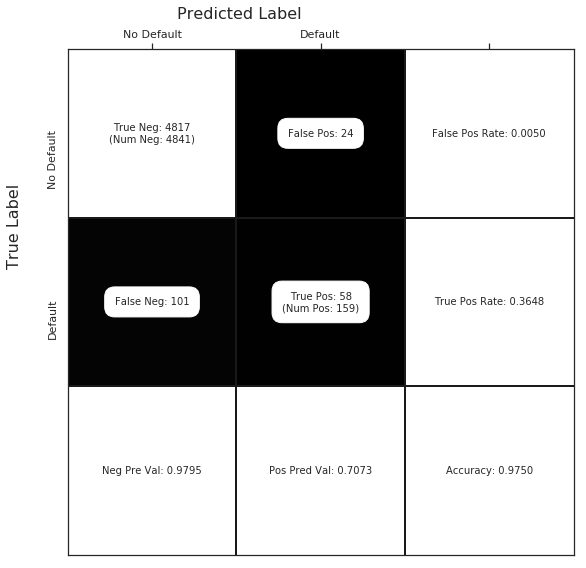

In [16]:
C = confusion_matrix(Y_test, Y_pred)
show_confusion_matrix(C, ['No Default', 'Default'])

[kembali ke atas](#Soal-5)

## 3

In [17]:
C = [C]
for i in range(1,4):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)
    model = LR.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    C.append(confusion_matrix(Y_test, Y_pred))

/home/uulwake/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/uulwake/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/uulwake/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [18]:
tpr, fpr, ppv, npv, acc = ([] for i in range(5))

for c in C:
    tn = c[0,0] 
    fp = c[0,1]
    fn = c[1,0]
    tp = c[1,1]
    tpr.append((tp / (tp+fn+0.)))
    fpr.append((fp / (fp+tn+0.)))
    ppv.append((tp/(tp+fp+0.)))
    npv.append((1-fn/(fn+tn+0.)))
    acc.append(((tp+tn+0.)/(tn+fp+fn+tp)))

In [19]:
def line(l):
    return " ".join( '{:06.4f}'.format(a) for a in l) + ', Average: ' +'{:06.4f}'.format(sum(l)/ len(l))

print('TPR: ')
print(line(tpr))
print('FPR: ')
print(line(fpr))
print('PPV: ')
print(line(ppv))
print('NPV: ')
print(line(npv))
print('ACC: ')
print(line(acc))

TPR: 
0.3648 0.3452 0.3030 0.3293, Average: 0.3356
FPR: 
0.0050 0.0029 0.0041 0.0029, Average: 0.0037
PPV: 
0.7073 0.8056 0.7143 0.7941, Average: 0.7553
NPV: 
0.9795 0.9777 0.9767 0.9777, Average: 0.9779
ACC: 
0.9750 0.9752 0.9730 0.9752, Average: 0.9746


[kembali ke atas](#Soal-5)

## 4

In [20]:
default['student_yes'] = (default['student'] == 'Yes').astype('int')

In [21]:
default.head()

,default,student,balance,income,default_yes,student_yes
1,No,No,729.526495,44361.625074,0,0
2,No,Yes,817.180407,12106.134700,0,1
3,No,No,1073.549164,31767.138947,0,0
4,No,No,529.250605,35704.493935,0,0
5,No,No,785.655883,38463.495879,0,0


In [22]:
X = default[['income','balance','student_yes']]
Y = default['default_yes']

f = 'default_yes ~ income + balance + student_yes'

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)
train = X_train.join(Y_train)


result = smf.logit(formula=f, data=train).fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.083936
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            default_yes   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4996
Method:                           MLE   Df Model:                            3
Date:                Thu, 21 Feb 2019   Pseudo R-squ.:                  0.4239
Time:                        09:57:52   Log-Likelihood:                -419.68
converged:                       True   LL-Null:                       -728.48
                                        LLR p-value:                1.548e-133
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -9.5279      0.639    -14.920      0.000     -10.780      -8.276
income      -1.429e-05   1.13e-05     -1.265      0.206   -3.64e-05    7.85e-06
balance         0.0053      0.000     17.416      0.000       0.005       0.006
student_yes    -0.8567      0.317     -2.704      0.007      -1.478      -0.236
===============================================================================

Possibly complete quasi-separation: A fraction 0.11 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [23]:
Y_pred = (result.predict(X_test) > .5) * 1

In [24]:
Y_pred.shape

(5000,)

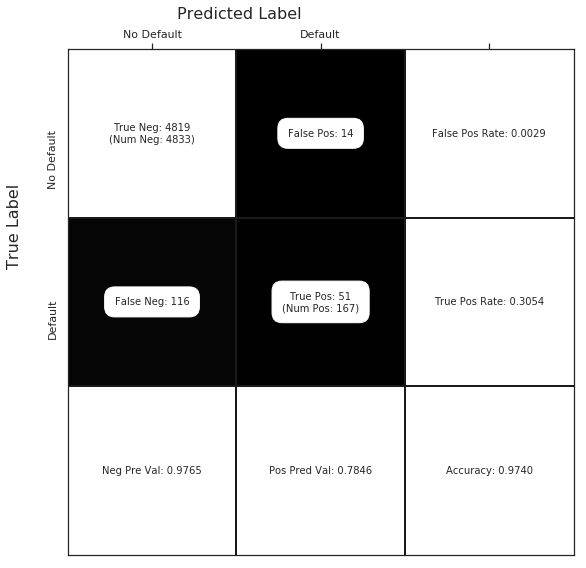

In [25]:
C = confusion_matrix(Y_test, Y_pred)
show_confusion_matrix(C, ['No Default', 'Default'])

[kembali ke atas](#Soal-5)